# Convolutional neural networks

In [1]:
#Required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, MaxPooling2D
from keras.layers import BatchNormalization, Dropout 
from keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Rescaling
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

 ## LeNet-5

### Data Loading

In [9]:
image_size=(32,32)
batch_size=16
color_mode='grayscale'

train_ds = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/ivobo/notebook/Machine Learning/train/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/ivobo/notebook/Machine Learning/test/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [10]:
# Extract image and label arrays from train set
X_train, y_train=[], []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train=np.array(X_train)
y_train=np.array(y_train)

# Shuffle the data if needed
shuffle_indices=np.arange(len(X_train))
np.random.shuffle(shuffle_indices)

X_train=X_train[shuffle_indices]
y_train=y_train[shuffle_indices]

# Extract image and label arrays from test set
X_test, y_test=[], []
for images, labels in test_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test=np.array(X_test)
y_test=np.array(y_test)

# Shuffle the data
shuffle_indices=np.arange(len(X_test))
np.random.shuffle(shuffle_indices)

X_test=X_test[shuffle_indices]
y_test=y_test[shuffle_indices]

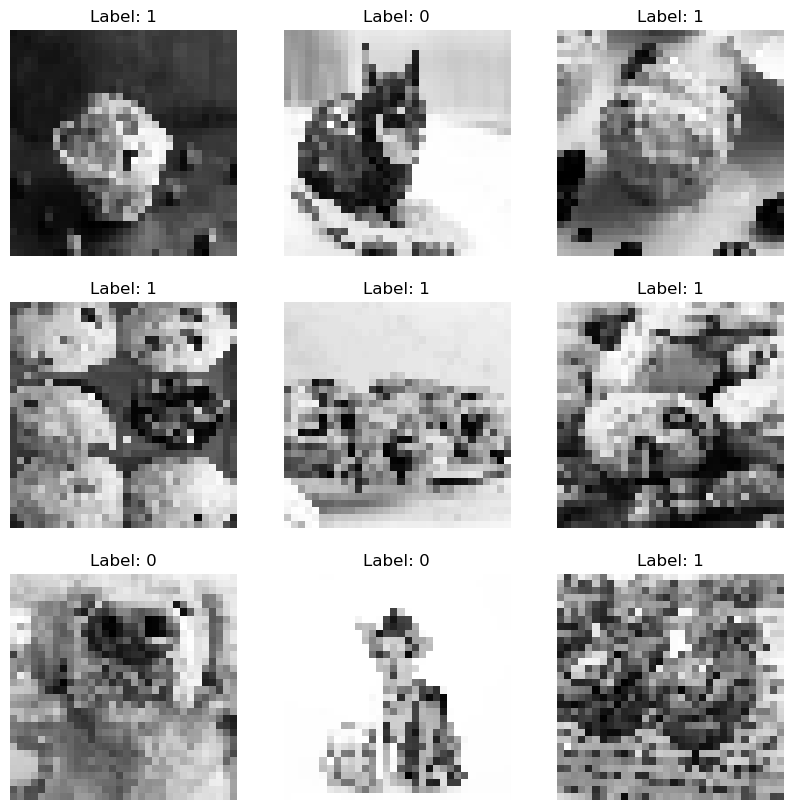

In [37]:
#visualizing the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().reshape(image_size), cmap='gray')
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")

plt.show()

### Model architecture

In [38]:
lenet5=Sequential([
    Conv2D(6, (5, 5), activation='tanh', input_shape=(32,32,1)),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='tanh'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='sigmoid'),
    Dense(84, activation='sigmoid'),
    Dense(1, activation='sigmoid')
    ])

lenet5.summary()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_214 (Conv2D)         (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_214 (Ave  (None, 14, 14, 6)         0         
 ragePooling2D)                                                  
                                                                 
 conv2d_215 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_215 (Ave  (None, 5, 5, 16)          0         
 ragePooling2D)                                                  
                                                                 
 flatten_107 (Flatten)       (None, 400)               0         
                                                                 
 dense_321 (Dense)           (None, 120)            

### Tuning and  running 5 folds cross validation 

In [39]:
#function that returns the model required by KerasClassifier
def lenet_5():
    lenet5 = Sequential()
    lenet5.add(Conv2D(6, (5, 5), activation='tanh', input_shape=(32, 32, 1)))
    lenet5.add(AveragePooling2D(pool_size=(2, 2)))
    lenet5.add(Conv2D(16, (5, 5), activation='tanh'))
    lenet5.add(AveragePooling2D(pool_size=(2, 2)))
    lenet5.add(Flatten())
    lenet5.add(Dense(120, activation='sigmoid'))
    lenet5.add(Dense(84, activation='sigmoid'))
    lenet5.add(Dense(1, activation='sigmoid'))
    return lenet5

# Wrap the Keras model so that it can be used by scikit-learn
lenet5=KerasClassifier(model=lenet_5, loss='binary_crossentropy', epochs=30, 
                       verbose=0)

# Create the RandomSearchCV object with 5-fold cross-validation
param_dist={'optimizer__learning_rate': [0.0001, 0.001], 'batch_size': [16,32],
            'optimizer': ['adam', 'sgd']}
random_search=RandomizedSearchCV(estimator=lenet5, param_distributions=param_dist,
                  cv=StratifiedKFold(n_splits=5), scoring='accuracy', #0-1 loss
                  n_iter=4, verbose=3) 

# Implement early stopping to avoid overfitting
early_stopping=EarlyStopping(monitor='val_loss', patience=8, 
                             restore_best_weights=False) 
model_checkpoint=ModelCheckpoint('lenet5', save_best_only=True, 
                                 monitor='val_loss', mode='min', verbose=1)

# Fit the random search to the data
random_search_result=random_search.fit(X_train, y_train,
                     callbacks=[early_stopping, model_checkpoint])  

# Print the best parameters and their corresponding 0-1 loss
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.790 total time=  37.0s
[CV 2/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.792 total time=  38.8s
[CV 3/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.765 total time=  39.9s
[CV 4/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.779 total time=  39.8s
[CV 5/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.762 total time=  42.1s
[CV 1/5] END batch_size=16, optimizer=adam, optimizer__learning_rate=0.001;, score=0.746 total time= 1.1min
[CV 2/5] END batch_size=16, optimizer=adam, optimizer__learning_rate=0.001;, score=0.760 total time= 1.1min
[CV 3/5] END batch_size=16, optimizer=adam, optimizer__learning_rate=0.001;, score=0.779 total time= 1.1min
[CV 4/5] END batch_size=16, optimizer=adam, optimizer__learning_rate=0.

### Testing the best model

In [12]:
tf.get_logger().setLevel('WARNING')

#Test the model with the best hyperameters on the full dataset 
final_lenet5=Sequential()
final_lenet5.add(Conv2D(6, (5, 5), activation='tanh', input_shape=(32, 32, 1)))
final_lenet5.add(AveragePooling2D(pool_size=(2, 2)))
final_lenet5.add(Conv2D(16, (5, 5), activation='tanh'))
final_lenet5.add(AveragePooling2D(pool_size=(2, 2)))
final_lenet5.add(Flatten())
final_lenet5.add(Dense(120, activation='sigmoid'))
final_lenet5.add(Dense(84, activation='sigmoid'))
final_lenet5.add(Dense(1, activation='sigmoid'))

if random_search_result.best_params_['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=random_search_result.best_params_['optimizer__learning_rate'])
else :
    optimizer = SGD(learning_rate=random_search_result.best_params_['optimizer__learning_rate'])

final_lenet5.compile(optimizer=optimizer, loss='binary_crossentropy', 
                     metrics=['accuracy'])

model_checkpoint=ModelCheckpoint('final_lenet5',save_best_only=True, 
                                 monitor='val_accuracy', mode='max',
                                 verbose=0)

history=final_lenet5.fit(X_train, y_train, epochs=30, 
                         batch_size=32,
                         #batch_size=random_search_result.best_params_['batch_size'], 
                         validation_data=(X_test, y_test), 
                         callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
148/148 [==============================] - 8s 39ms/step - loss: 0.7133 - accuracy: 0.5160 - val_loss: 0.6804 - val_accuracy: 0.5355
Epoch 2/30
148/148 [==============================] - 4s 30ms/step - loss: 0.6713 - accuracy: 0.5821 - val_loss: 0.6518 - val_accuracy: 0.6571
Epoch 3/30
148/148 [==============================] - 4s 28ms/step - loss: 0.6360 - accuracy: 0.6584 - val_loss: 0.6052 - val_accuracy: 0.6858
Epoch 4/30
148/148 [==============================] - 4s 25ms/step - loss: 0.5953 - accuracy: 0.6966 - val_loss: 0.5701 - val_accuracy: 0.7027
Epoch 5/30
148/148 [==============================] - 4s 30ms/step - loss: 0.5648 - accuracy: 0.7143 - val_loss: 0.5399 - val_accuracy: 0.7407
Epoch 6/30
148/148 [==============================] - 4s 30ms/step - loss: 0.5356 - accuracy: 0.7441 - val_loss: 0.5204 - val_accuracy: 0.7458
Epoch 7/30
148/148 [==============================] - 5s 31ms/step - loss: 0.5209 - accuracy: 0.7503 - val_loss: 0.5055 - val_accuracy: 0.7601

In [13]:
#load best model weights
final_lenet5.load_weights("final_lenet5")
#Compile model and retrieve the validation accuracy
final_lenet5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
scores = final_lenet5.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (final_lenet5.metrics_names[1], scores[1]*100))

accuracy: 79.14%


### Visualizing the results

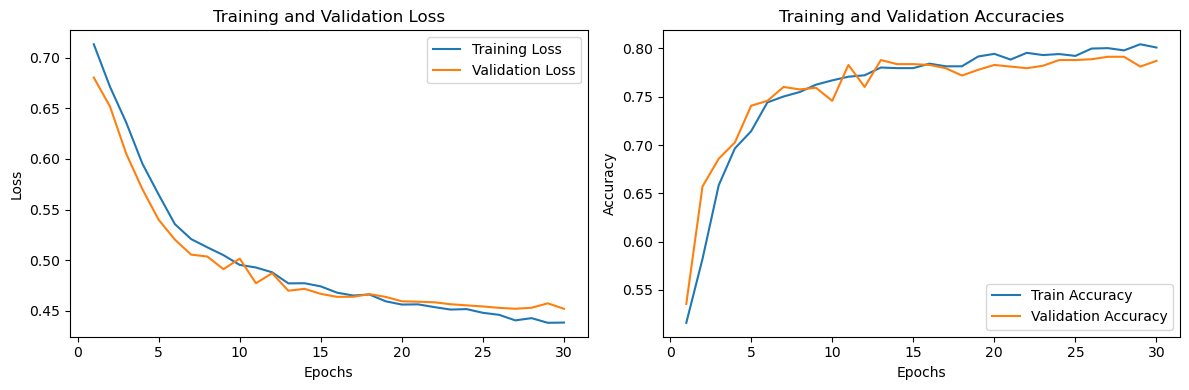

In [14]:
# Retrieve training and validation losses
loss=history.history['loss']
val_loss=history.history['val_loss']

#Retrieve training and validation accuracies
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

# Plot validation loss against epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies against epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## AlexNet-simplified

### Data loading

In [15]:
image_size=(64,64)
batch_size=32
color_mode='rgb'

train_ds = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/ivobo/notebook/Machine Learning/train/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/ivobo/notebook/Machine Learning/test/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [16]:
# Extract image and label arrays from train set
X_train, y_train=[], []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train=np.array(X_train)
y_train=np.array(y_train)

# Shuffle the data if needed
shuffle_indices=np.arange(len(X_train))
np.random.shuffle(shuffle_indices)

X_train=X_train[shuffle_indices]
y_train=y_train[shuffle_indices]

# Extract image and label arrays from test set
X_test, y_test=[], []
for images, labels in test_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test=np.array(X_test)
y_test=np.array(y_test)

# Shuffle the data
shuffle_indices=np.arange(len(X_test))
np.random.shuffle(shuffle_indices)

X_test=X_test[shuffle_indices]
y_test=y_test[shuffle_indices]

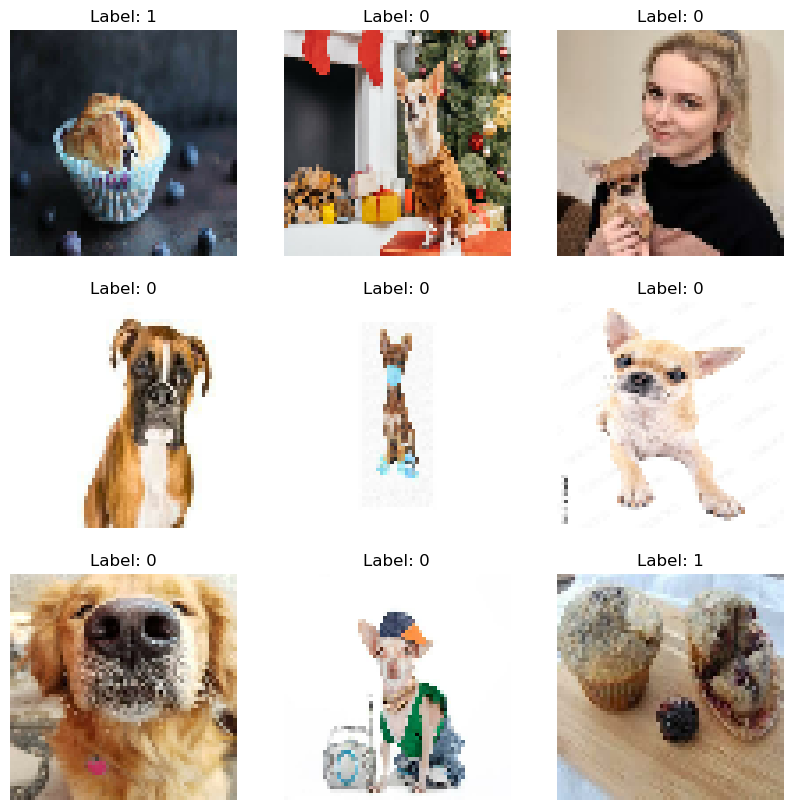

In [17]:
#visualizign the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")

plt.show()

### Model architecture

In [18]:
alexnetSimp=Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

alexnetSimp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 flatten_5 (Flatten)         (None, 18432)            

### Tuning and running 5 folds cross validation

In [19]:
#avoid to display warnings
tf.get_logger().setLevel('WARNING')

#function that returns the model required by KerasClassifier
def alexnet_simp():
    alexnetSimp = Sequential()
    alexnetSimp.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    alexnetSimp.add(MaxPooling2D(2, 2))
    alexnetSimp.add(Conv2D(64, (3, 3), activation='relu'))
    alexnetSimp.add(MaxPooling2D(2, 2))
    alexnetSimp.add(Conv2D(128, (3, 3), activation='relu'))
    alexnetSimp.add(Flatten())
    alexnetSimp.add(Dense(128, activation='relu'))
    alexnetSimp.add(Dense(1, activation='sigmoid'))
    return alexnetSimp

# Wrap the Keras model so that it can be used by scikit-learn
alexnetSimp=KerasClassifier(model=alexnet_simp, loss='binary_crossentropy',
                            epochs=30, verbose=0)

# Create the RandomSearchCV object with 5-fold cross-validation
param_dist={'optimizer__learning_rate': [0.0001, 0.001], 'batch_size': [32,64],
            'optimizer': ['adam', 'sgd']}
random_search=RandomizedSearchCV(estimator=alexnetSimp, param_distributions=param_dist,
                                 cv=StratifiedKFold(n_splits=5), scoring='accuracy', #0-1 loss
                                 n_iter=4, verbose=3) 

# Implement early stopping to avoid overfitting
early_stopping=EarlyStopping(monitor='val_loss', patience=8, 
                             restore_best_weights=False) 
model_checkpoint=ModelCheckpoint('alexnetSimp', save_best_only=True, 
                                 monitor='val_loss', mode='min', verbose=1)

# Fit the random search to the data
random_search_result=random_search.fit(X_train, y_train,
                     callbacks=[early_stopping, model_checkpoint])   

# Print the best parameters and their corresponding 0-1 loss
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.001;, score=0.827 total time= 6.3min
[CV 2/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.001;, score=0.870 total time= 6.1min
[CV 3/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.001;, score=0.830 total time= 6.1min
[CV 4/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.001;, score=0.878 total time= 6.5min
[CV 5/5] END batch_size=32, optimizer=adam, optimizer__learning_rate=0.001;, score=0.876 total time= 6.0min
[CV 1/5] END batch_size=64, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.866 total time= 4.9min
[CV 2/5] END batch_size=64, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.870 total time= 4.9min
[CV 3/5] END batch_size=64, optimizer=adam, optimizer__learning_rate=0.0001;, score=0.850 total time= 3.7min
[CV 4/5] END batch_size=64, optimizer=adam, optimizer__learning_rate=0.00

### Testing the best model

In [72]:
# avoid to display warnings
tf.get_logger().setLevel('WARNING')

#Test the model with the best hyperameters on the full dataset 
final_alexnetsimp=Sequential()
#data augmentation
final_alexnetsimp.add(Rescaling(1./255))
#final_alexnetsimp.add(RandomTranslation(height_factor=0.2, width_factor=0.2))
final_alexnetsimp.add(RandomFlip("horizontal"))
final_alexnetsimp.add(RandomRotation(0.2))
#final_alexnetsimp.add(RandomZoom(0.2))
#architecture
final_alexnetsimp.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
final_alexnetsimp.add(MaxPooling2D(2, 2))
final_alexnetsimp.add(Conv2D(64, (3, 3), activation='relu'))
final_alexnetsimp.add(MaxPooling2D(2, 2))
final_alexnetsimp.add(Conv2D(128, (3, 3), activation='relu'))
final_alexnetsimp.add(Flatten())
final_alexnetsimp.add(Dense(128, activation='relu'))
final_alexnetsimp.add(Dense(1, activation='sigmoid'))

if random_search_result.best_params_['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=random_search_result.best_params_['optimizer__learning_rate'])
else :
    optimizer = SGD(learning_rate=random_search_result.best_params_['optimizer__learning_rate'])

final_alexnetsimp.compile(optimizer=optimizer, loss='binary_crossentropy', 
                          metrics=['accuracy'])

model_checkpoint=ModelCheckpoint('final_alexnetsimp',save_best_only=True, 
                                 monitor='val_accuracy', mode='max',
                                 verbose=0)

history=final_alexnetsimp.fit(X_train, y_train, epochs=30,
                              batch_size=random_search.best_params_['batch_size'], 
                              validation_data=(X_test, y_test), 
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
74/74 [==============================] - 11s 129ms/step - loss: 0.5814 - accuracy: 0.6947 - val_loss: 0.4846 - val_accuracy: 0.7711
Epoch 2/30
74/74 [==============================] - 9s 119ms/step - loss: 0.4600 - accuracy: 0.7896 - val_loss: 0.3867 - val_accuracy: 0.8361
Epoch 3/30
74/74 [==============================] - 9s 117ms/step - loss: 0.4022 - accuracy: 0.8270 - val_loss: 0.3842 - val_accuracy: 0.8378
Epoch 4/30
74/74 [==============================] - 8s 104ms/step - loss: 0.3922 - accuracy: 0.8267 - val_loss: 0.4299 - val_accuracy: 0.8277
Epoch 5/30
74/74 [==============================] - 8s 115ms/step - loss: 0.3483 - accuracy: 0.8472 - val_loss: 0.3340 - val_accuracy: 0.8606
Epoch 6/30
74/74 [==============================] - 9s 117ms/step - loss: 0.3198 - accuracy: 0.8616 - val_loss: 0.2952 - val_accuracy: 0.8801
Epoch 7/30
74/74 [==============================] - 9s 128ms/step - loss: 0.3040 - accuracy: 0.8734 - val_loss: 0.2673 - val_accuracy: 0.8919
Epoch

In [73]:
#load best model weights
final_alexnetsimp.load_weights("final_alexnetsimp")
#Compile model and retrieve the validation accuracy
final_alexnetsimp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
scores = final_alexnetsimp.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (final_alexnetsimp.metrics_names[1], scores[1]*100))

accuracy: 90.88%


### Visualizing the results

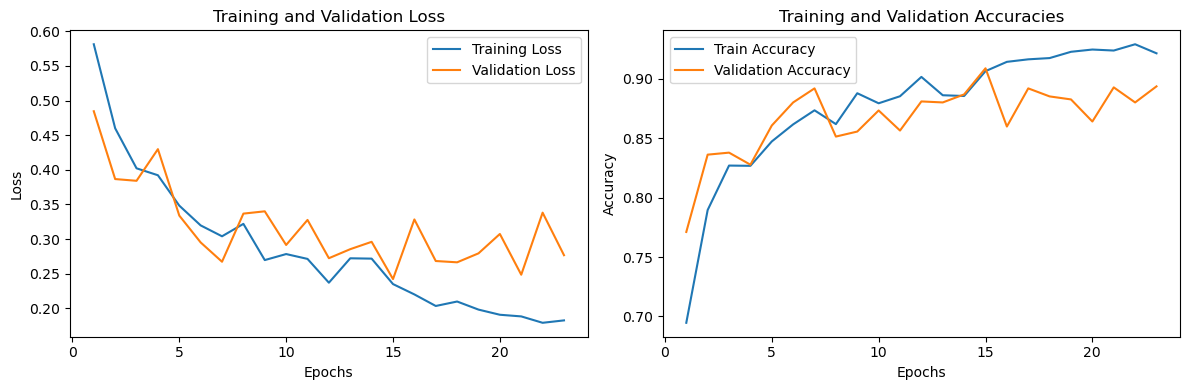

In [74]:
#Retrieve training and validation losses
loss=history.history['loss']
val_loss=history.history['val_loss']

#Retrieve training and validation accuracies
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

# Plot validation loss against epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies against epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## AlexNet

### Data loading

In [2]:
image_size=(224,224)
batch_size=32
color_mode='rgb'

train_ds = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/ivobo/notebook/Machine Learning/train/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/ivobo/notebook/Machine Learning/test/',
  seed=123,
  image_size=image_size,
  color_mode=color_mode,
  label_mode='binary',
  batch_size=batch_size)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [3]:
# Extract image and label arrays from train set
X_train, y_train=[], []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train=np.array(X_train)
y_train=np.array(y_train)

# Shuffle the data if needed
shuffle_indices=np.arange(len(X_train))
np.random.shuffle(shuffle_indices)

X_train=X_train[shuffle_indices]
y_train=y_train[shuffle_indices]

# Extract image and label arrays from test set
X_test, y_test=[], []
for images, labels in test_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test=np.array(X_test)
y_test=np.array(y_test)

# Shuffle the data
shuffle_indices=np.arange(len(X_test))
np.random.shuffle(shuffle_indices)

X_test=X_test[shuffle_indices]
y_test=y_test[shuffle_indices]

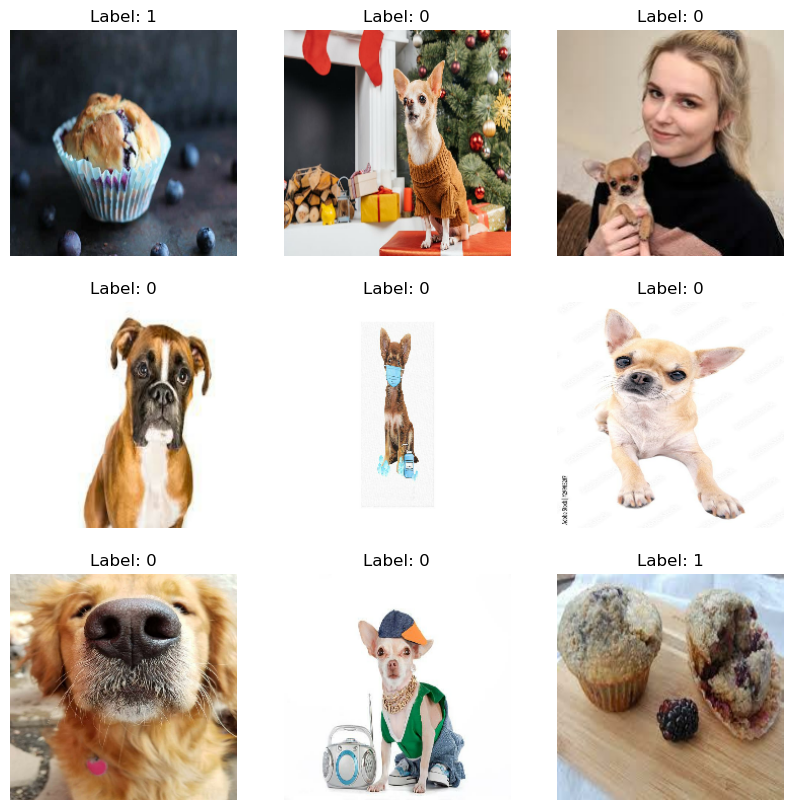

In [4]:
#visualizign the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")

plt.show()

### Model architecture

In [5]:
alexnet=Sequential([
    Conv2D(filters=96, kernel_size=(11,11), activation='relu', strides=(4,4), 
           input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),          
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),         
    Dense(1, activation='sigmoid')
    ])

alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 26, 26, 256)       1024      
 chNormalization)                                                
                                                        

### Testing the best model

Given the computational cost, the model is trained on Google Colab with 150 epochs to exploit the GPU access. 
Colab link: https://github.com/ivobonfanti/Machine-learning.git

In [6]:
#avoid to display warnings
tf.get_logger().setLevel('WARNING')

#Test the model with the best hyperameters on the full dataset 
final_alexnet=Sequential()
#preprocessing and augmentation
final_alexnet.add(Rescaling(1./255))
final_alexnet.add(RandomTranslation(height_factor=0.2, width_factor=0.2))
final_alexnet.add(RandomFlip("horizontal"))
final_alexnet.add(RandomRotation(0.2))
final_alexnet.add(RandomZoom(0.2))
#architecture
final_alexnet.add(Conv2D(filters=96, kernel_size=(11,11), activation='relu', strides=(4,4), 
                  input_shape=(224, 224, 3)))
final_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
final_alexnet.add(Conv2D(filters=256, kernel_size=(5,5), activation='relu', 
                  padding='same'))
final_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
final_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu',
                  padding='same'))
final_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu',
                  padding='same'))
final_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu',
                  padding='same'))
final_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
final_alexnet.add(Flatten())
final_alexnet.add(Dense(4096, activation='relu'))
final_alexnet.add(Dropout(0.5))
final_alexnet.add(Dense(4096, activation='relu'))
final_alexnet.add(Dropout(0.5))
final_alexnet.add(Dense(1, activation='sigmoid'))

optimizer=Adam(learning_rate=0.0005)
final_alexnet.compile(optimizer=optimizer, loss='binary_crossentropy', 
                      metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss', patience=8, 
                             restore_best_weights=False) 
model_checkpoint=ModelCheckpoint('final_alexnet',save_best_only=True, 
                                 monitor='val_accuracy', mode='max',
                                 verbose=0)

history=final_alexnet.fit(X_train, y_train, epochs=25,
                          batch_size=128,
                          validation_data=(X_test, y_test), 
                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/25
37/37 [==============================] - 202s 5s/step - loss: 0.7121 - accuracy: 0.5453 - val_loss: 0.6750 - val_accuracy: 0.5498
Epoch 2/25
37/37 [==============================] - 180s 5s/step - loss: 0.6853 - accuracy: 0.5548 - val_loss: 0.6645 - val_accuracy: 0.6486
Epoch 3/25
37/37 [==============================] - 195s 5s/step - loss: 0.6350 - accuracy: 0.6516 - val_loss: 0.5992 - val_accuracy: 0.6968
Epoch 4/25
37/37 [==============================] - 211s 6s/step - loss: 0.5532 - accuracy: 0.7260 - val_loss: 0.4968 - val_accuracy: 0.7796
Epoch 5/25
37/37 [==============================] - 204s 6s/step - loss: 0.5392 - accuracy: 0.7424 - val_loss: 0.5026 - val_accuracy: 0.7812
Epoch 6/25
37/37 [==============================] - 194s 5s/step - loss: 0.5380 - accuracy: 0.7346 - val_loss: 0.4863 - val_accuracy: 0.7753
Epoch 7/25
37/37 [==============================] - 198s 5s/step - loss: 0.4986 - accuracy: 0.7653 - val_loss: 0.4590 - val_accuracy: 0.7956
Epoch 8/25
37

### Visualizing the results

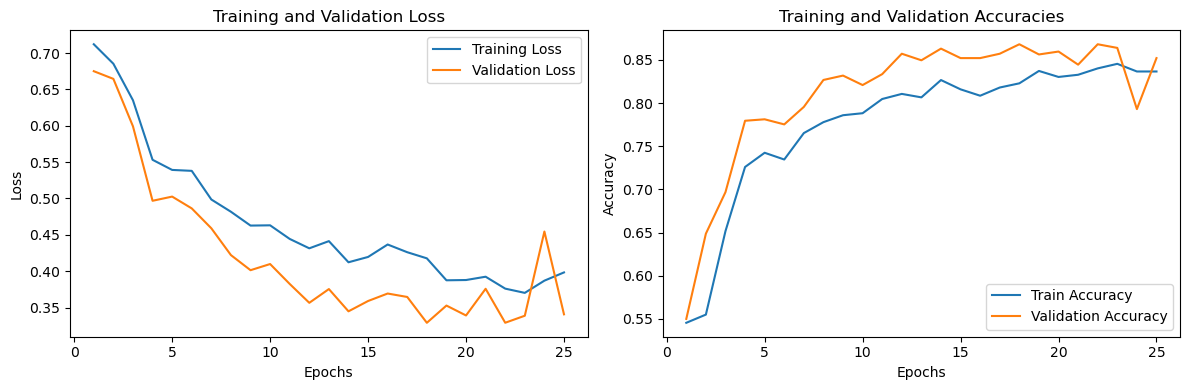

In [7]:
#Retrieve training and validation losses
loss=history.history['loss']
val_loss=history.history['val_loss']

#Retrieve training and validation accuracies
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

# Plot validation loss against epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies against epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()